In [1]:
# Import libraries and stuff
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
import sklearn
%load_ext autoreload
%autoreload 3

In [2]:
import utils_linear_response
from fast_algorithm import compute_quantile, compute_quantile_analytical, compute_quantile_analytical_tau, compute_quantile_analytical_tau_discrete 

The goal is to make the scripts as fast as the Спутник 1 before leaving us for the beauty of Space Exploration.

## Section: Synthetic model

Here we define the synthetic model used for tests and experiments.

## Section: Responses and statistical significance

#### Parameters

Define the parameters for both the Markov model and responses.

#### Run Markov Model

Run the Markov Model forward in time

#### Compute the true responses

Compute the ground truth for responses

#### Estimate responses

Estimate responses through covariance functions

#### Compute statistical significance

Quantify undertainty through ensemble of null models

#### Plotting

Plot these results

#### Compute causal stregth

Compute (a) the cumulative degree of causation and (b) the total causal strength of each node.

# Synthetic model

3 dimensional Markov model usedfor testing

In [3]:
# Synthetic data definition: 
# time series are autocorrelated
# linear relationships

def linear_markov_system(a,b,epsilon,period):

    ########## Define the data matrix
    data_t = np.zeros([period, 3])
    data_t[0,0] = np.random.normal(loc=0, scale=1)
    data_t[0,1] = np.random.normal(loc=0, scale=1)
    data_t[0,2] = np.random.normal(loc=0, scale=1)
    
    ########## Transition matrix
    A = np.array([
        [a,epsilon,0],
        [a,a,0],
        [a,0,a]
    ])

    # forward integration
    for t in range(period-1):
        data_t[t+1] = np.matmul(A,data_t[t]) + b*np.random.normal(loc=0, scale=1,size = 3)
        
    return data_t   

# transition matrix
def A_matrix(a,epsilon):
    ########## Transition matrix
    A = np.array([
        [a,epsilon,0],
        [a,a,0],
        [a,0,a]
    ])
    
    return A

# Responses and Statistical Significance

### Parameters

In [4]:
### Parameters for Markov Model

a = 0.5
b = 1
# epsilon
epsilon = 0.04
# period: length of the time series
period = 1000

### Parameters for Response

# we compute responses up to a lag tau_max
tau_max = 20
# we compute covariances
standardized = 'yes'

### Run Markov Model

In [5]:
########## Run model forward in time
orbit = linear_markov_system(a,b,epsilon,period)
orbit = np.transpose(orbit)
# Time length
n_time = np.shape(orbit)[1]
# Number of time series
n_ts = np.shape(orbit)[0]

### Compute the TRUE response

In [6]:
########## Ground truth

matrix_A = A_matrix(a,epsilon)
from numpy.linalg import matrix_power

true_response = []
tau_max = 20

for tau in range(tau_max):
        
    ########## Compute the response matrix ground truth
    true_response.append(matrix_power(matrix_A,tau))
    
true_response = np.array(true_response)    

In [7]:
np.save('./results/true_response.npy',true_response)

### Estimate responses

In [8]:
########## Compute the response matrix
response_matrix = utils_linear_response.response(orbit,tau_max,standardized)

In [9]:
np.save('./results/response_matrix.npy',response_matrix)

### Compute statistical Significance

In [10]:
# Generate R null models with same 
# mean, variance and lag-1 autocorrelation of the original time series
# and compute the response matrix for each sample

############################## Step (a)
# Compute the lag 1 autocorrelation

# lag-1 autocorrelation
print('Computing lag-1 autocorr')
phi = utils_linear_response.phi_vector(orbit)

############################## Step (b)
# Compute standard deviations of each time series

# sigmas
print('Computing sigmas')
sigmas = utils_linear_response.sigmas(orbit)

############################## Step (c)

# For each time series generate a null model
# and compute its responses

# Number of samples
R = 1000

import time
start = time.time()

print('Computing ensemble of null models')
null_responses_samples = utils_linear_response.null_responses(orbit,phi,tau_max,sigmas,R,standardized)


end = time.time()
print('Finished in '+str(round(end - start, 2))+' seconds')

Computing lag-1 autocorr
Computing sigmas
Computing ensemble of null models
Progress: 0.1 of 1
Progress: 0.2 of 1
Progress: 0.3 of 1
Progress: 0.4 of 1
Progress: 0.5 of 1
Progress: 0.6 of 1
Progress: 0.7 of 1
Progress: 0.8 of 1
Progress: 0.9 of 1
Progress: 1.0 of 1
Finished in 31.43 seconds


In [11]:
null_response_0p99_quantile = np.quantile(null_responses_samples,0.99,axis = 0)
null_response_0p01_quantile = np.quantile(null_responses_samples,0.01,axis = 0)

In [12]:
np.save('./results/null_response_0p99_quantile.npy',null_response_0p99_quantile)
np.save('./results/null_response_0p01_quantile.npy',null_response_0p01_quantile)

# New code

In [17]:
%%time
null_response_0p01_quantile, null_response_0p99_quantile = compute_quantile(orbit,phi,sigmas,tau_max,R)

Expected memory consumption in GB: 0.002251267433166504
Memory is allocating...
Memory is allocated
Trajectory and inverse 100/100 are computed for 0.01 sec
Trajectories and inverse matrices are ready
Lag 20/20 is computed for 0.0 sec
Quantiles are computed
CPU times: user 1.95 s, sys: 2.61 s, total: 4.56 s
Wall time: 2.31 s


In [33]:
np.save('./results/null_response_0p99_quantile.npy',null_response_0p99_quantile)
np.save('./results/null_response_0p01_quantile.npy',null_response_0p01_quantile)

# Analytical

In [18]:
q01, q99 = compute_quantile_analytical_tau(orbit,phi,sigmas,tau_max,R)

In [20]:
q01, q99 = compute_quantile_analytical_tau_discrete(orbit,phi,sigmas,tau_max,R)

### Plotting

In [14]:
true_response = np.load('./results/true_response.npy')
response_matrix = np.load('./results/response_matrix.npy')
null_response_0p99_quantile = np.load('./results/null_response_0p99_quantile.npy')
null_response_0p01_quantile = np.load('./results/null_response_0p01_quantile.npy')

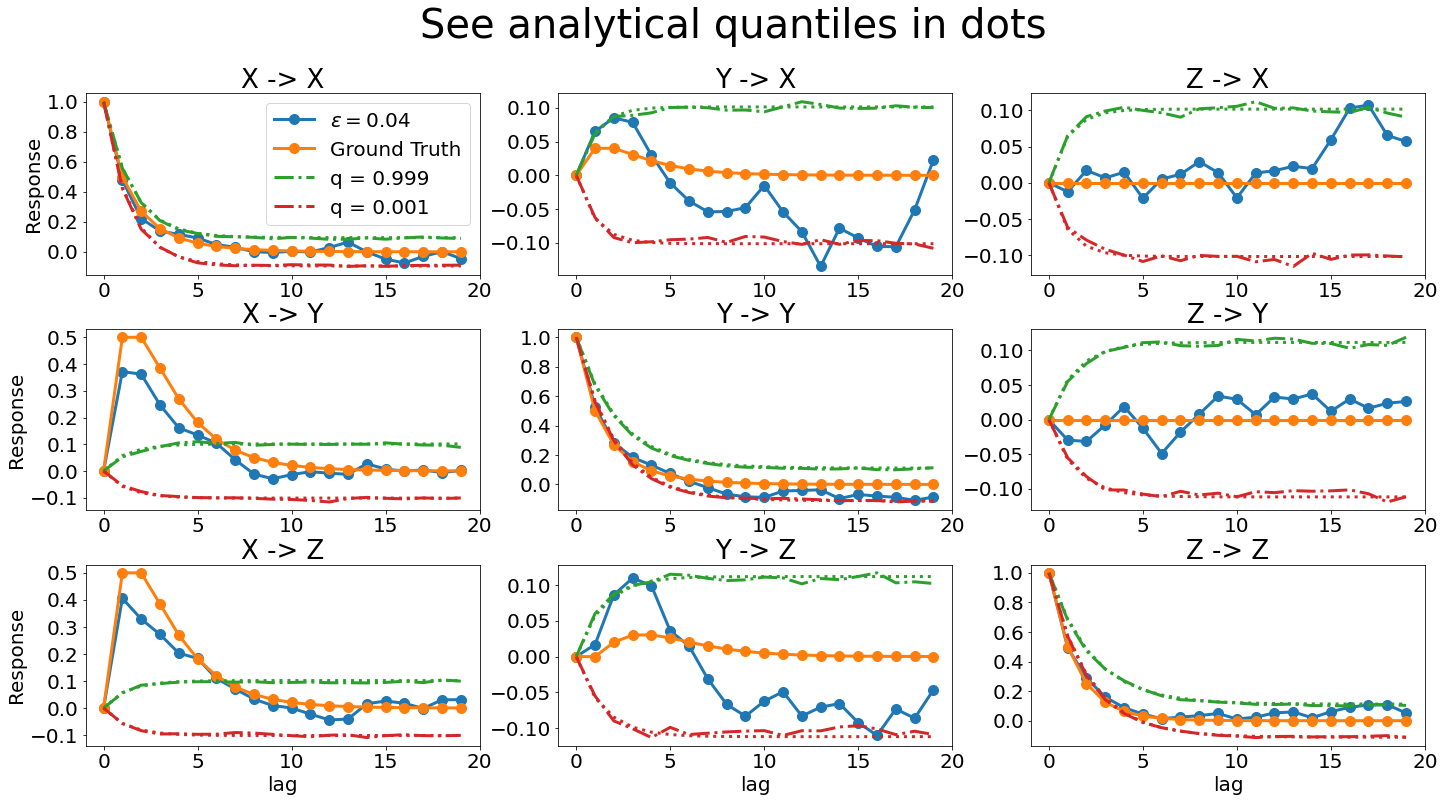

In [21]:
fig = plt.figure(figsize=(24,12))

for i in range(3):
    
    for j in range(3):
        
        if i == 0:
            subplot_idx = j + 1
        if i == 1:
            subplot_idx = j + 4
        if i == 2:
            subplot_idx = j + 7    

        ax = plt.subplot(3, 3, subplot_idx)
        plt.plot(response_matrix[:,i,j],'.-',label = '$\epsilon = 0.04$',linewidth = 3,markersize = 20)
        plt.plot(true_response[:,i,j],'.-',label = 'Ground Truth',linewidth = 3,markersize = 20)
        plt.plot(null_response_0p99_quantile[:,i,j],'-.',label = 'q = 0.999',linewidth = 3,markersize = 20)
        plt.plot(null_response_0p01_quantile[:,i,j],'-.',label = 'q = 0.001',linewidth = 3,markersize = 20)
        plt.plot(q99[:,i,j],':', color='tab:green', linewidth = 3,markersize = 20)
        plt.plot(q01[:,i,j],':', color='tab:red', linewidth = 3,markersize = 20)
        
        if i == 0 and j == 0:
            plt.legend(fontsize = 20)
            
        if i == 0 and j == 0 or i == 1 and j == 0 or i == 2 and j == 0:
            plt.ylabel('Response',fontsize = 20)
            
        if i == 2 and j == 0 or i == 2 and j == 1 or i == 2 and j == 2:
            plt.xlabel('lag',fontsize = 20)  
            
        title_fontsize = 26    
            
        if i == 0 and j == 0:
            plt.title('X -> X',fontsize = title_fontsize)
        if i == 1 and j == 1:
            plt.title('Y -> Y',fontsize = title_fontsize) 
        if i == 2 and j == 2:
            plt.title('Z -> Z',fontsize = title_fontsize) 
            
        if i == 0 and j == 1:
            plt.title('Y -> X',fontsize = title_fontsize)
        if i == 0 and j == 2:
            plt.title('Z -> X',fontsize = title_fontsize) 
            
        if i == 1 and j == 0:
            plt.title('X -> Y',fontsize = title_fontsize)
        if i == 1 and j == 2:
            plt.title('Z -> Y',fontsize = title_fontsize)
            
        if i == 2 and j == 0:
            plt.title('X -> Z',fontsize = title_fontsize)
        if i == 2 and j == 1:
            plt.title('Y -> Z',fontsize = title_fontsize)     
        
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        ax.set_xticks([0,5,10,15,20])
        ax.set_xticklabels(['0','5','10','15','20'])
        
        plt.subplots_adjust(wspace=0.2, hspace=0.3)
        
plt.suptitle('See analytical quantiles in dots', fontsize=40)
fig.savefig('./discrete.pdf',bbox_inches='tight') 

### Compute causal strength 

$\textit{Cumulative degree of causation}$

Given $x^{(j)} \rightarrow x^{(k)}$ we compute the "Cumulative degree of causation" as $\mathcal{D}_{j \rightarrow k} = \sum_{t = 1}^{\infty} \mid R_{t}^{k,j} \mid.$ We name this "strengths_j_k".

$\textit{Causal strength of node j}$

Given a node $x^{(j)}$ we define its "Causal strength" as $\mathcal{D}_{j} = \sum_{k} \sum_{t = 1}^{\infty} \mid R_{t}^{k,j} \mid.$ We name this "strengths_j".

Importanty, summations are made only on statistical significant values of $R$.

In [85]:
# Function to define node_strength with statistical significance
# (I am sure there is a better way to write it. I am tired so whatever.)

def node_strength_significance(response_matrix,significance_right_tail,significance_left_tail):
    
    # Inputs
    # - response_matrix
    # - significance_right_tail: for example the 99th percentile of the ensemble of null models
    # - significance_left_tail: for example the 1st percentile of the ensemble of null models
    
    # Outputs:
    # - strengths_j_k: strength of the connection j -> k
    # If the original response matrix is n by n, strengths_j_k will be n x (n - 1)
    # as it will not consider self links
    
    time = np.shape(response_matrix)[0]
    # number of rows = number of columns = n
    n = np.shape(response_matrix)[1]
    
    # response_matrix_significant: assign zero if not significant
    response_matrix_significant = response_matrix.copy()
    
    # if you are not significant we change you as zero
    for t in range(time):
        for j in range(n):
            for k in range(n):
                if ((response_matrix[t,k,j] < significance_right_tail[t,k,j]) and (response_matrix[t,k,j] > significance_left_tail[t,k,j])):
                    response_matrix_significant[t,k,j] = 0
    
    # Strength of link j -> k
    strengths_j_k = []
    
    for j in range(n):
        for k in range(n):
            # Response j -> k in absolute value
            abs_response_j_k = np.abs(response_matrix_significant[1:,k,j])
            # Compute strength of j -> k
            strengths_j_k.append(np.sum(abs_response_j_k)) 
                
    strengths_j_k = np.array(strengths_j_k)
    strengths_j_k = strengths_j_k.reshape(n,n)
    
    # When computing strengths we remove the j -> j connection
    # remove diagonal
    strengths_j_k_off_diagonal = strengths_j_k[~np.eye(strengths_j_k.shape[0],dtype=bool)].reshape(strengths_j_k.shape[0],-1)
    
    # Strength of node j
    strengths_j = np.sum(strengths_j_k_off_diagonal,axis = 1)
    
    return strengths_j_k, strengths_j

In [87]:
strengths_j_k, strengths_j = node_strength_significance(response_matrix,null_response_0p99_quantile,null_response_0p01_quantile)

In [98]:
for j in range(3):
    for k in range(3):
        print('Strength connections of node j = '+str(j)+' ---> k = '+str(k)+ ':  ' + str(strengths_j_k[j,k]) )
    print('')    

Strength connections of node j = 0 ---> k = 0:  0.8613147940514703
Strength connections of node j = 0 ---> k = 1:  1.6611109718262445
Strength connections of node j = 0 ---> k = 2:  1.7209599855469595

Strength connections of node j = 1 ---> k = 0:  0.18497468059409816
Strength connections of node j = 1 ---> k = 1:  1.13185803986816
Strength connections of node j = 1 ---> k = 2:  0.11804043445210749

Strength connections of node j = 2 ---> k = 0:  0.010686445707610464
Strength connections of node j = 2 ---> k = 1:  0.0
Strength connections of node j = 2 ---> k = 2:  1.0178567748100331



In [101]:
for j in range(3):
    print('Causal strength of node j = '+str(j)+ ':  ' + str(strengths_j[j]))

Causal strength of node j = 0:  3.382070957373204
Causal strength of node j = 1:  0.30301511504620565
Causal strength of node j = 2:  0.010686445707610464


In [1]:
np.fft.fft(np.zeros(100,10000), axis=-1)

NameError: name 'np' is not defined

# Real responses

In [25]:
orbit = np.load('./real_responses/average_signals_infomap_hp_filter_10yrs.npy')
response_matrix = np.load('./real_responses/response_matrix_filter_10yrs_correlations.npy')
null_response_99p9_percentile = np.load('./real_responses/null_response_99p9.npy')
null_response_0p1_percentile = np.load('./real_responses/null_response_0p1.npy')

In [26]:
phi = utils_linear_response.phi_vector(orbit)
sigmas = utils_linear_response.sigmas(orbit)

In [31]:
q0p1, q99p9 = compute_quantile_analytical_tau_discrete(orbit, phi, sigmas, 260, 0, q=[0.001, 0.999])

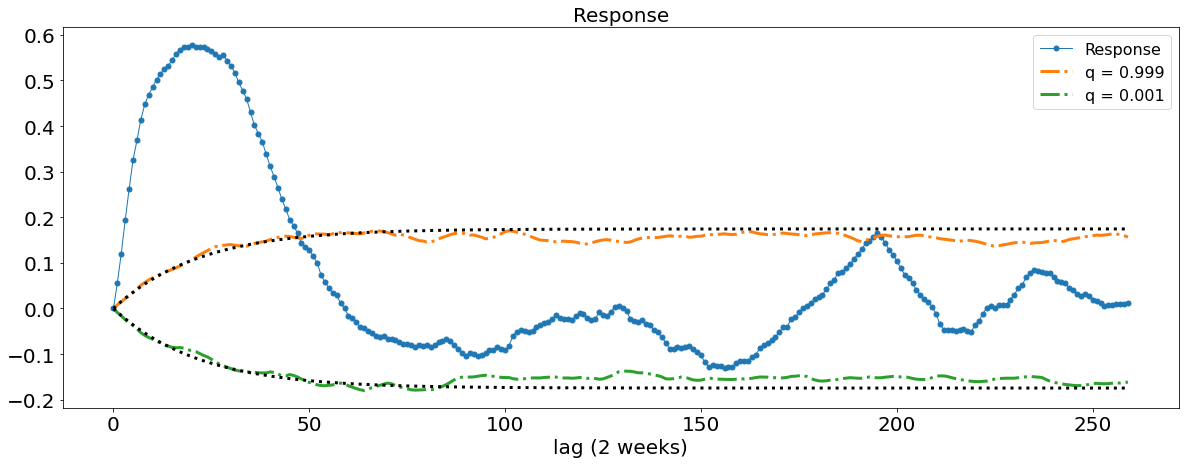

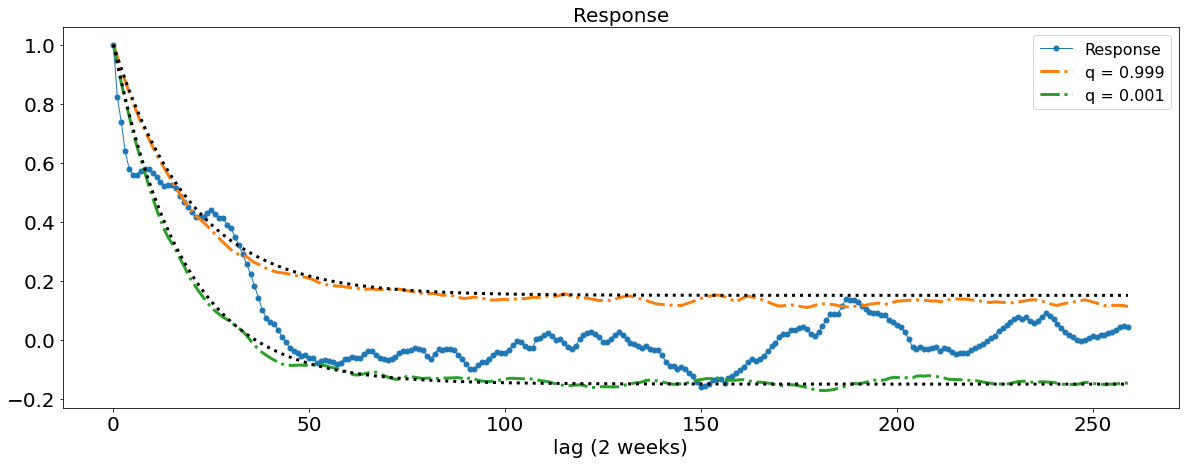

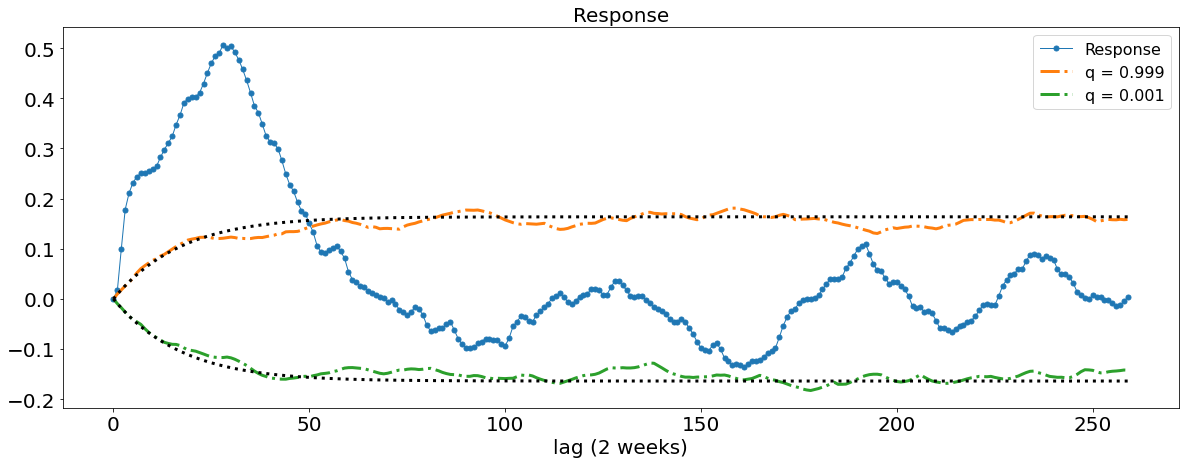

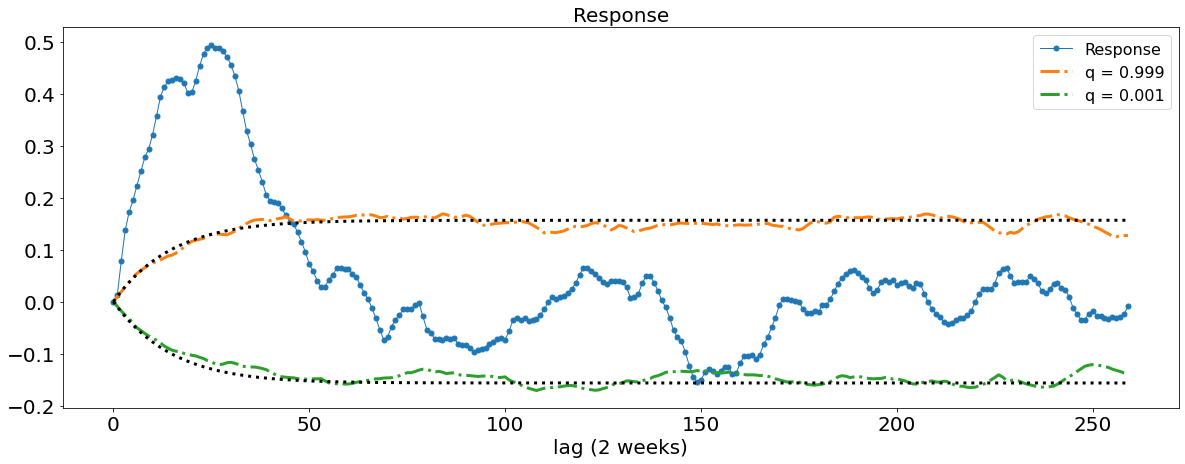

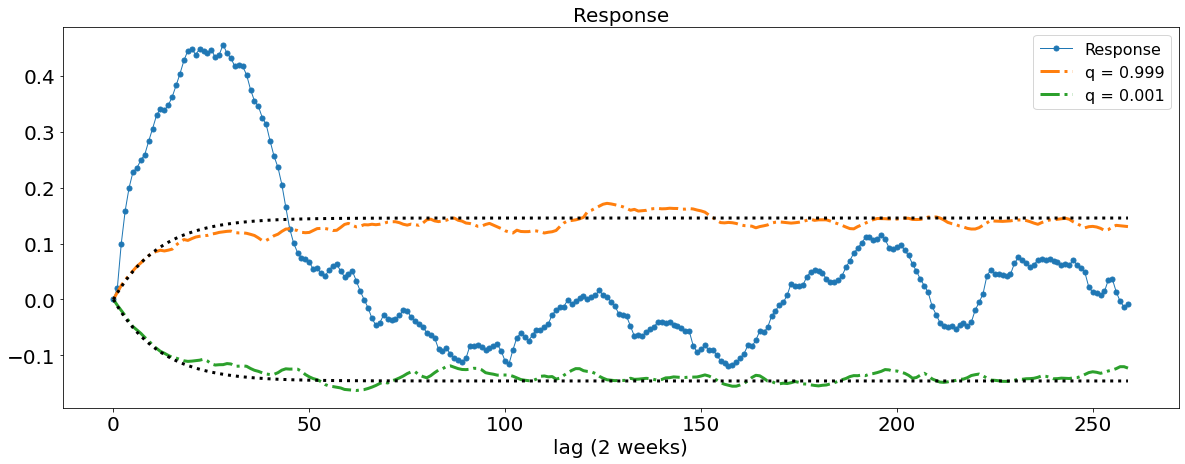

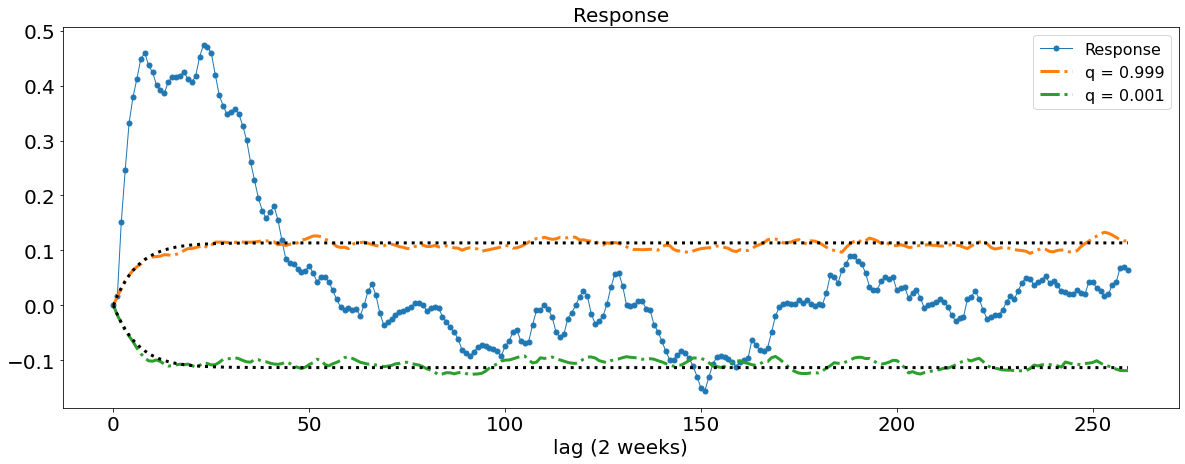

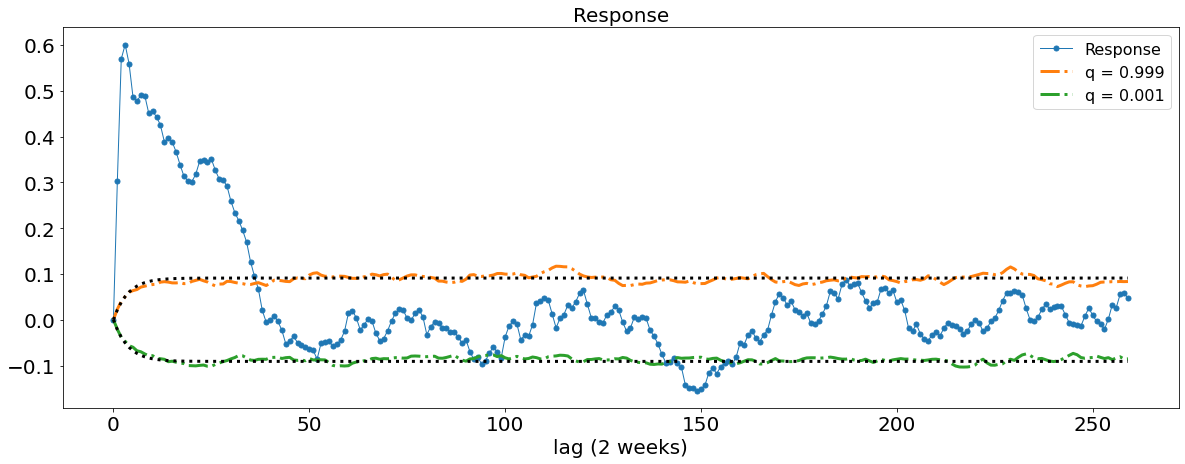

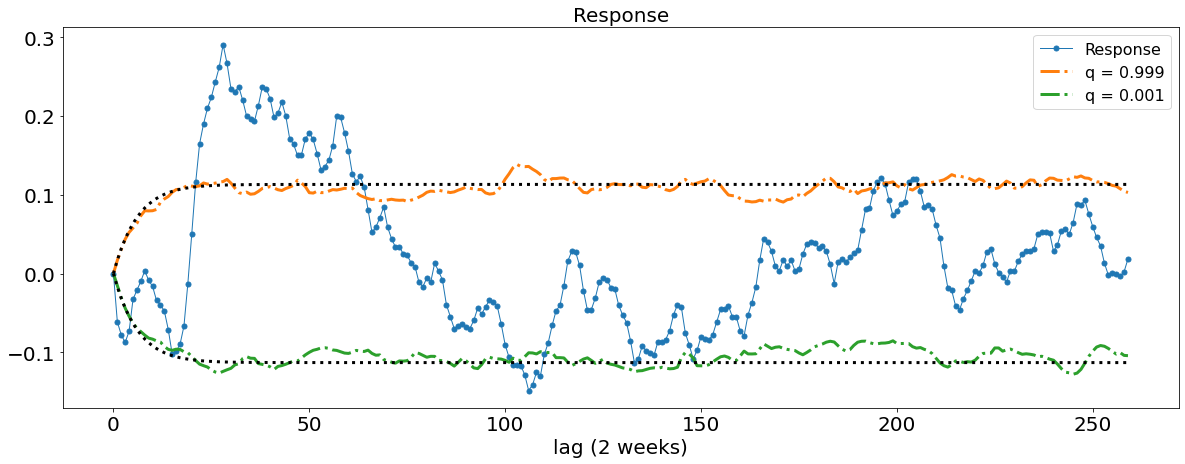

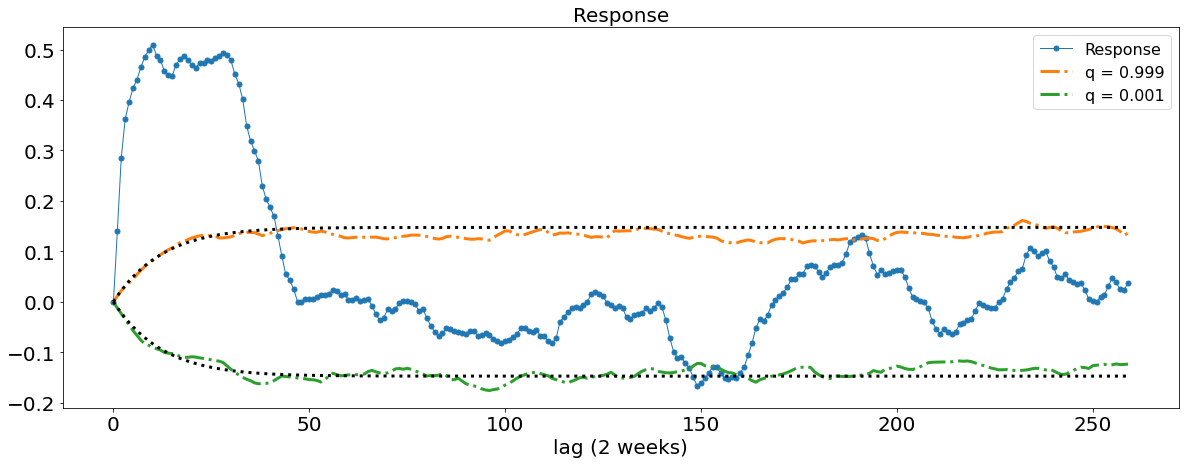

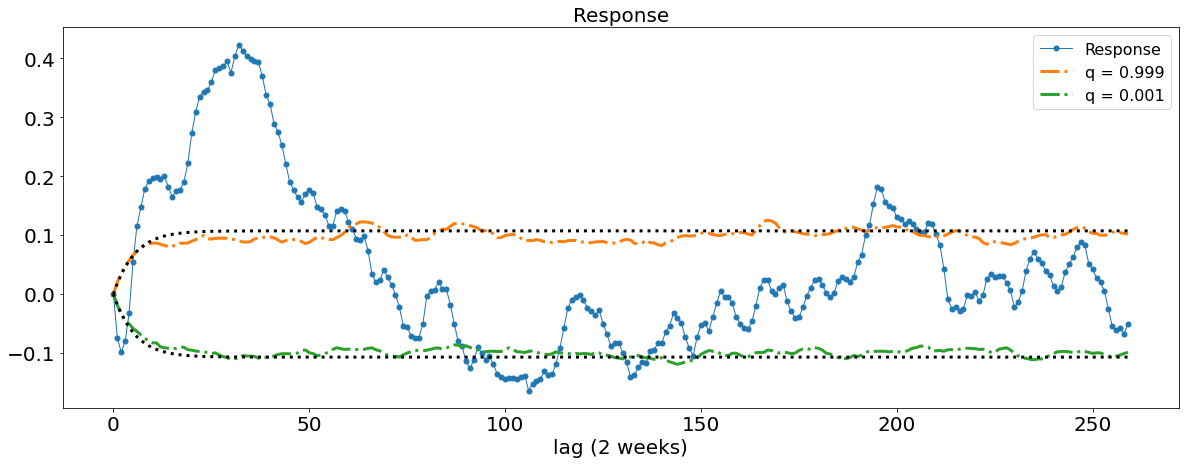

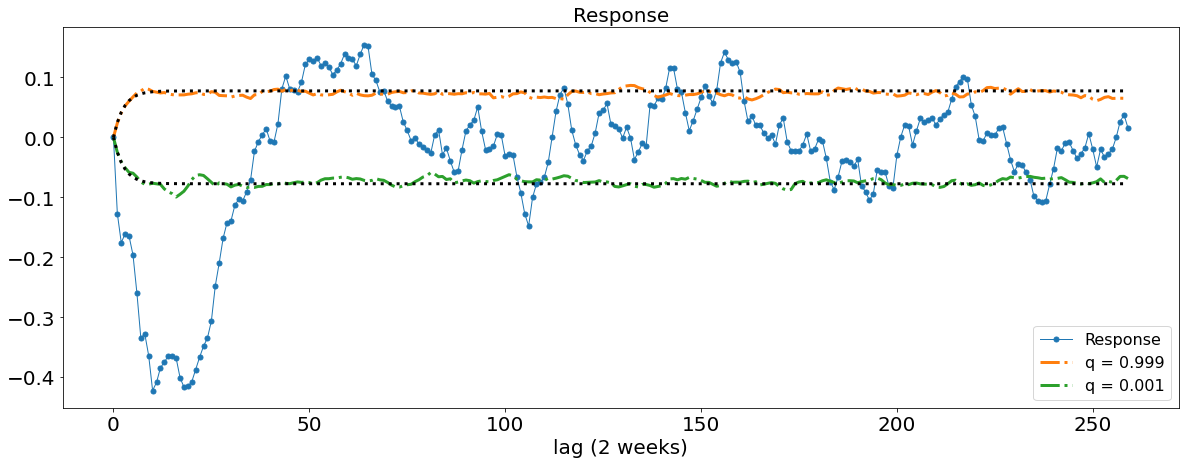

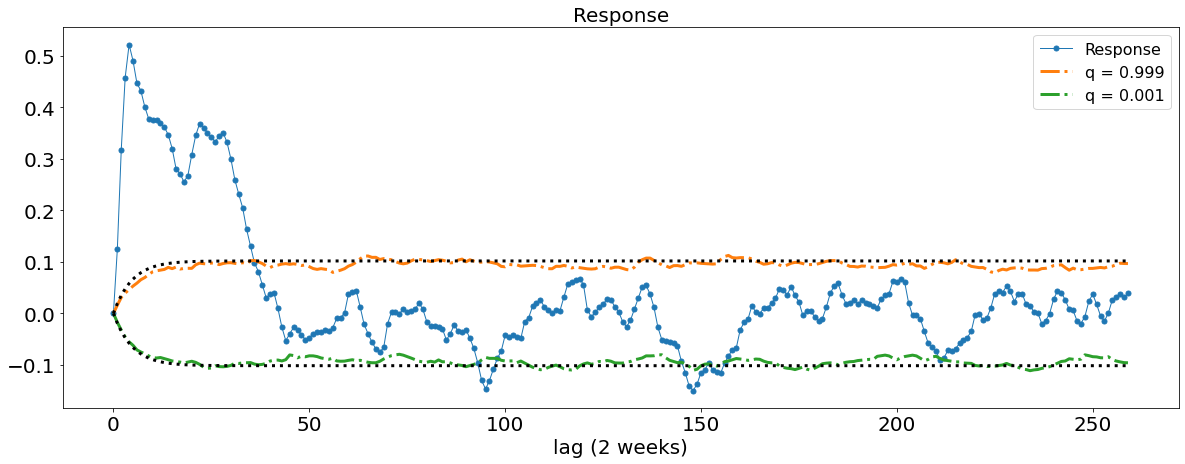

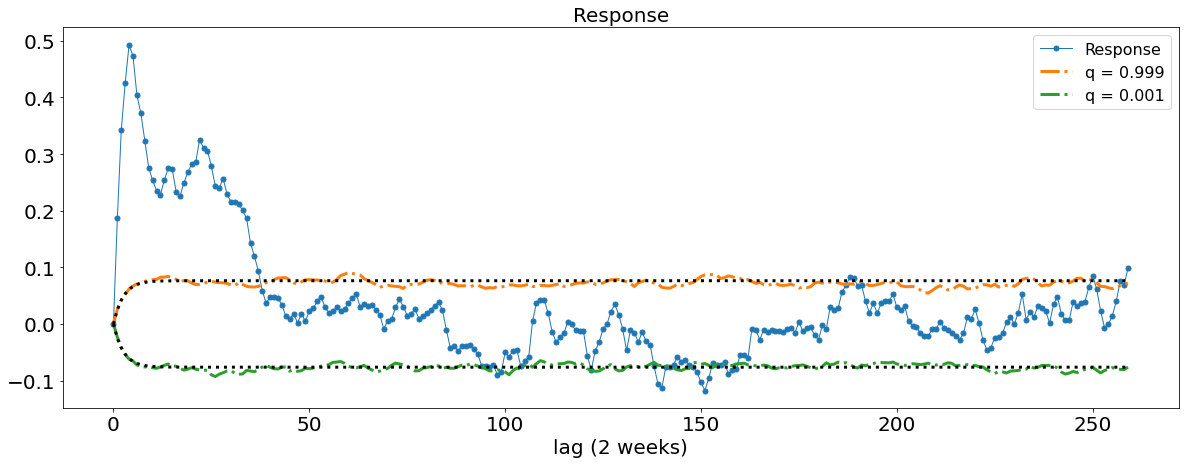

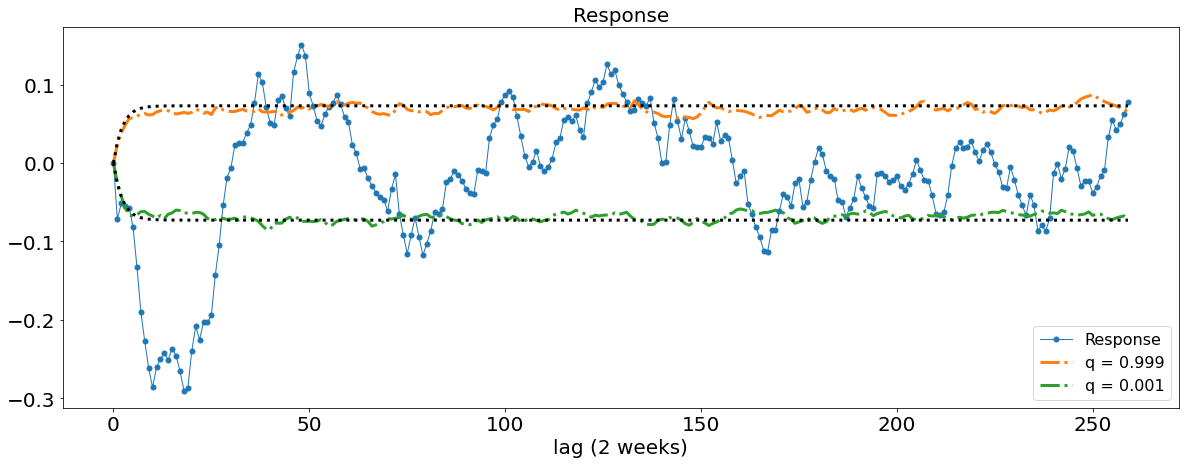

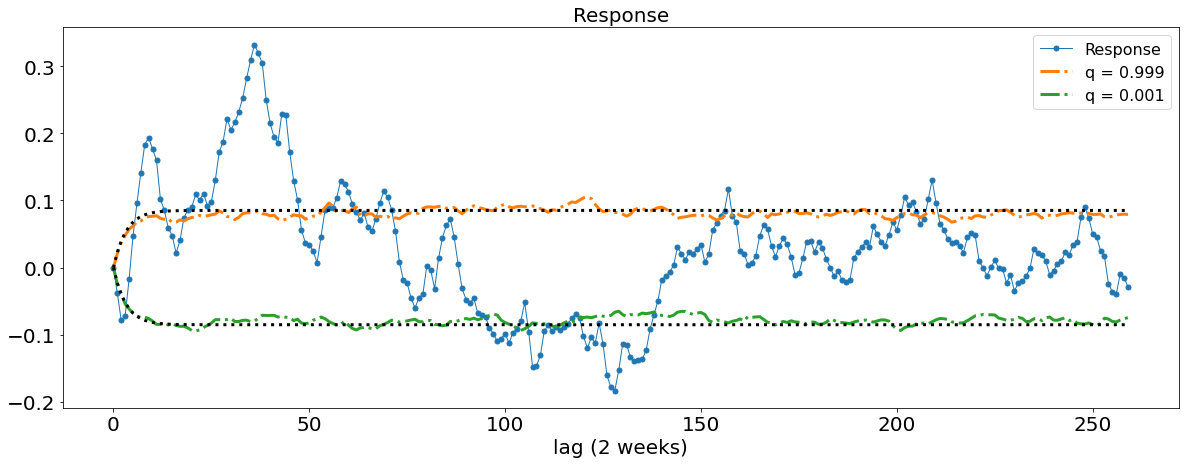

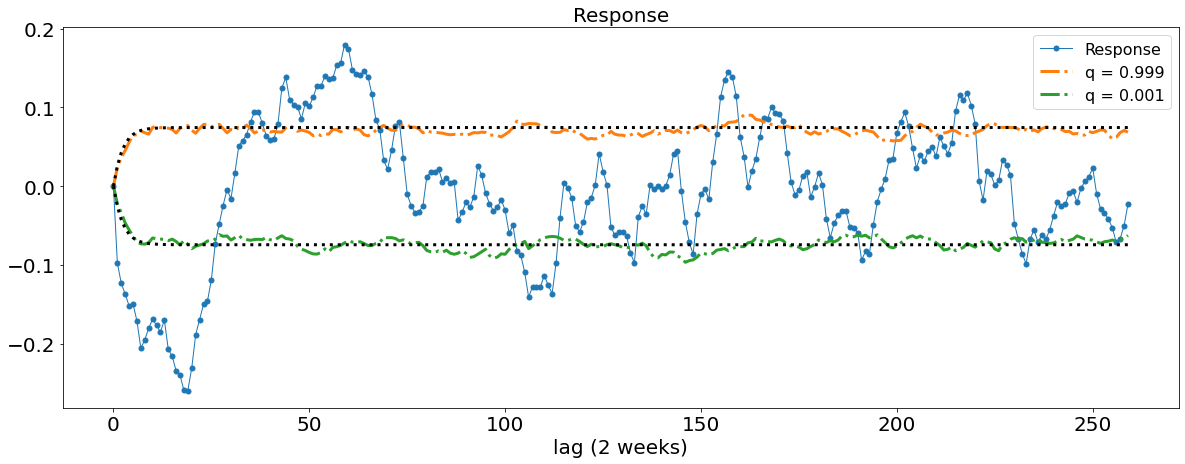

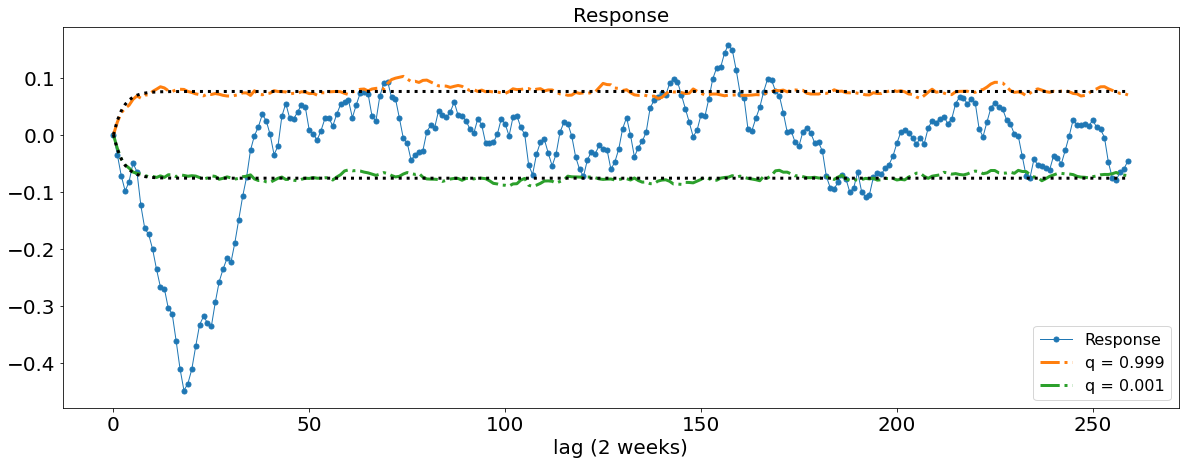

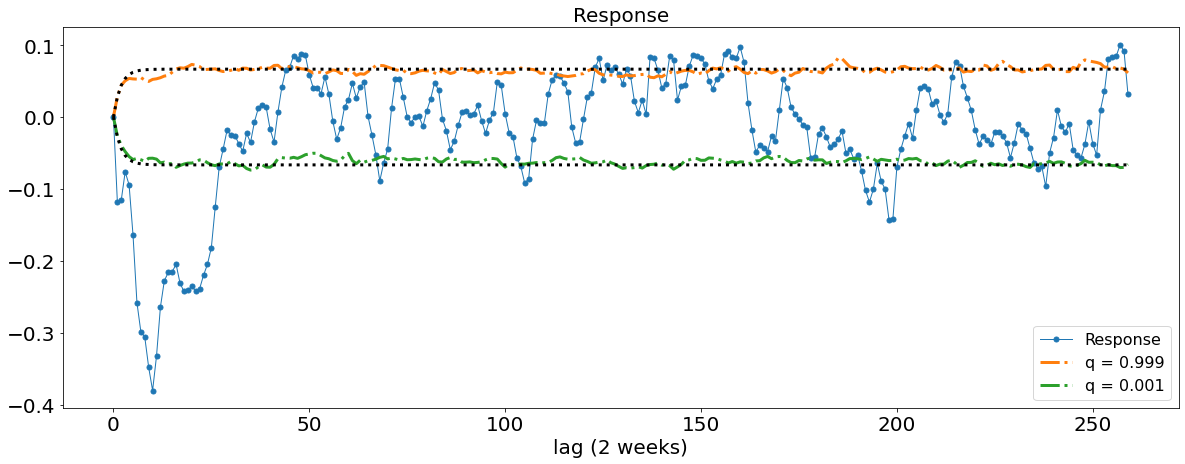

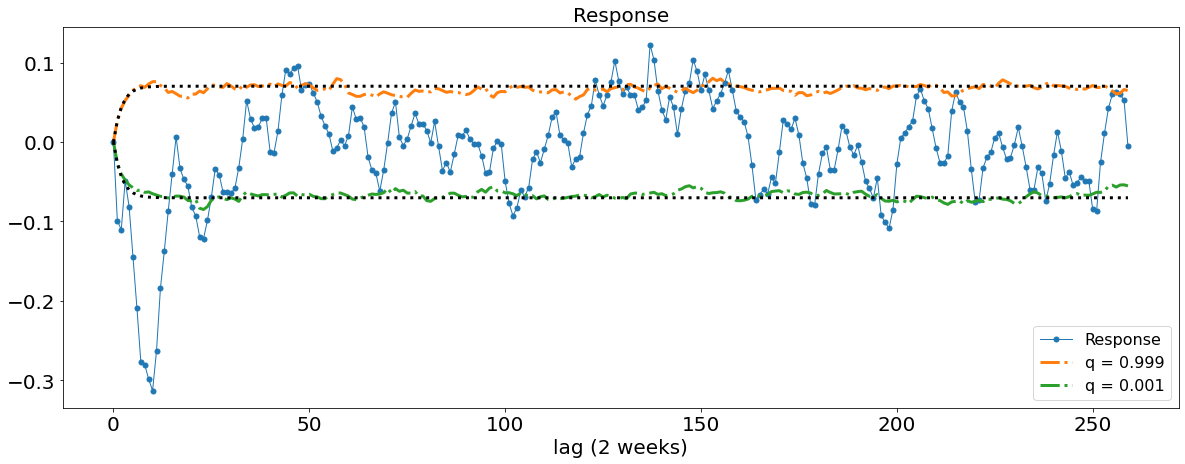

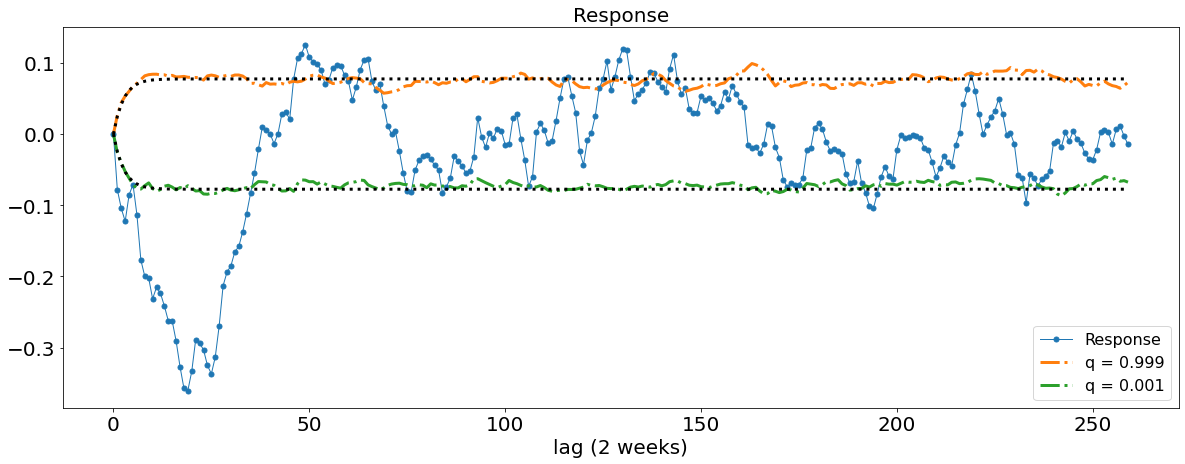

In [32]:
j = 1
for k in range(np.shape(response_matrix)[1]):
    
    
    fig = plt.figure(figsize=(20,7))

    ax = fig.add_subplot(111)  
    
    plt.plot(response_matrix[:,k,j],'.-',label = 'Response',linewidth = 1,markersize = 10)
    plt.plot(null_response_99p9_percentile[:,k,j],'-.',label = 'q = 0.999',linewidth = 3)
    plt.plot(null_response_0p1_percentile[:,k,j],'-.',label = 'q = 0.001',linewidth = 3)
    plt.plot(q99p9[:,k,j],':', linewidth = 3, color='k')
    plt.plot(q0p1[:,k,j],':',linewidth = 3, color='k')
    
    plt.legend(fontsize = 16)

    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    #ax.set_xticks([0,5,10,15,20])
    #ax.set_xticklabels(['0','5','10','15','20'])

    plt.xlabel('lag (2 weeks)',fontsize = 20)
    plt.title('Response',fontsize = 20)

    
    plt.subplots_adjust(wspace=0.15, hspace=0)
    
    
    plt.show()